In [1]:
# import, etc. setups
import numpy as np
from scipy import stats as ss
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy import stats as ss
import sys

sys.path.insert(1,'../src')

from  BayersianModel import BayersianModel
from Prior import Prior
from copy import deepcopy
import pandas as pd
import os
from MCMC import NaiveSampler

import statsmodels.api as sm

normal2d = np.random.multivariate_normal


# testing the sampling method

this notebook aims to test the correctness of my naive sampler by doing some quantitative analysis on the 2d gaussian. 

#### testing the sampler: correctness and efficiency
- compute effective sample size: i think warne has done this to his experiement 
- could there be a chi-square way, null hypothesis etc way of testing the confidence of this sampler? 
    - this works for independent samples, probabily not good for mcmc
    - this could work for 2d. 
- moment method
- summary statistics: this is the most easy way....
- auto-correlation might also be very helpful

In [2]:
# parameters
m0 = 0
m1 = 1
s0 = 2
s1 = 3
rho = -0.5
true_theta = (m0, m1, s0, s1, rho)
sample_size = 200

In [3]:
def reshape(theta):
    m0, m1, s0, s1, rho = theta
    mean = np.array([m0, m1])
    cov = np.array([
        [s0**2, s0*s1*rho],
        [s0*s1*rho, s1**2]
    ])
    return mean, cov


In [4]:
mean, cov = reshape(true_theta)


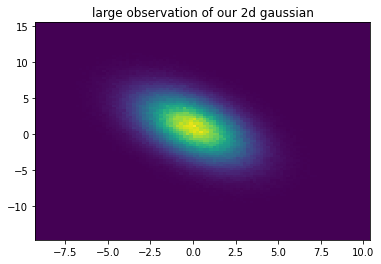

In [5]:
# large_observation to see the distribution of this 2d normal
large_observation = normal2d(mean, cov, 1000000)
plt.hist2d(large_observation[:, 0], large_observation[:, 1], bins=(100, 100))
plt.title('large observation of our 2d gaussian')
print()


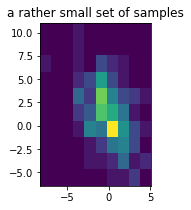

In [6]:
# observation
observation = normal2d(mean, cov, sample_size)
plt.figure(figsize=(2, 3))
plt.hist2d(observation[:, 0], observation[:, 1])
plt.title('a rather small set of samples')
print()


## parameter estimation

there are in total 5 parameters of a 2d gaussian distribution. they are
$$
\mu_0=0,\quad\mu_1=1,\quad std_0=1,\quad std_1 = 1,\quad \rho = 0.5
$$

And they only need to satisfy the constraint that
- $\rho \in [-1,1]$
- $std \ge 0$ (this is optional, but I choose so)

In [7]:
theta_range = np.array(((-10, 10), (-10, 10), (0, 10), (0, 10), (-1, 1))).T
constraints = (None, None, (0, np.inf), (0, np.inf), (-1, 1))


In [8]:
def flatten(theta):
    '''
    theta = (mean, cov)
    return 1d array
    '''
    mean, cov = theta
    m0, m1 = mean
    s0 = np.sqrt(cov[0][0])
    s1 = np.sqrt(cov[1][1])
    rho = cov[0, 1]/(s0*s1)

    return (m0, m1, s0, s1, rho)


def prior_sampler():
    return np.random.uniform(*theta_range)


def log_likelyhood(theta, observation):
    '''
    Inputs
      - theta = (mu,cov)
      - observation = ...

    Output
      - likelyhood of L(theta, observation)
    '''
    try:
        var = multivariate_normal(*reshape(theta))
        return np.sum([var.logpdf(observation)])
    except np.linalg.LinAlgError:
        return - np.inf


## Inference

In [9]:
burn_in = 200
prior = Prior(
    log_pdf=lambda _: 1,
    sampler=prior_sampler,
    theta_range=theta_range
)
model = BayersianModel(
    prior=prior,
    observation=observation,
    log_likelyhood=log_likelyhood,
)

naive_sampler = NaiveSampler(
    model,
    burn_in=200
)

In [83]:
n_pst = 100000
box_size = .15

In [84]:
pst_samples = naive_sampler.simulation(
    n=n_pst,
    theta_range=constraints,
    box_size=box_size)[200:]


sampling posterior: 100%|██████████| 100200/100200 [00:15<00:00, 6536.07it/s]

acceptance rate: 0.3112275449101796


In [85]:
M1, M2, S1, S2, R = pst_samples.T

mean_pst = pst_samples.cumsum(axis=0) / np.tile(np.arange(1,len(pst_samples) + 1),(5,1)).T
mean_M1, mean_M2, mean_S1, mean_S2, mean_R = mean_pst.T

Text(0.5, 1.0, 'MCMC est parameter v.s. True parameter')

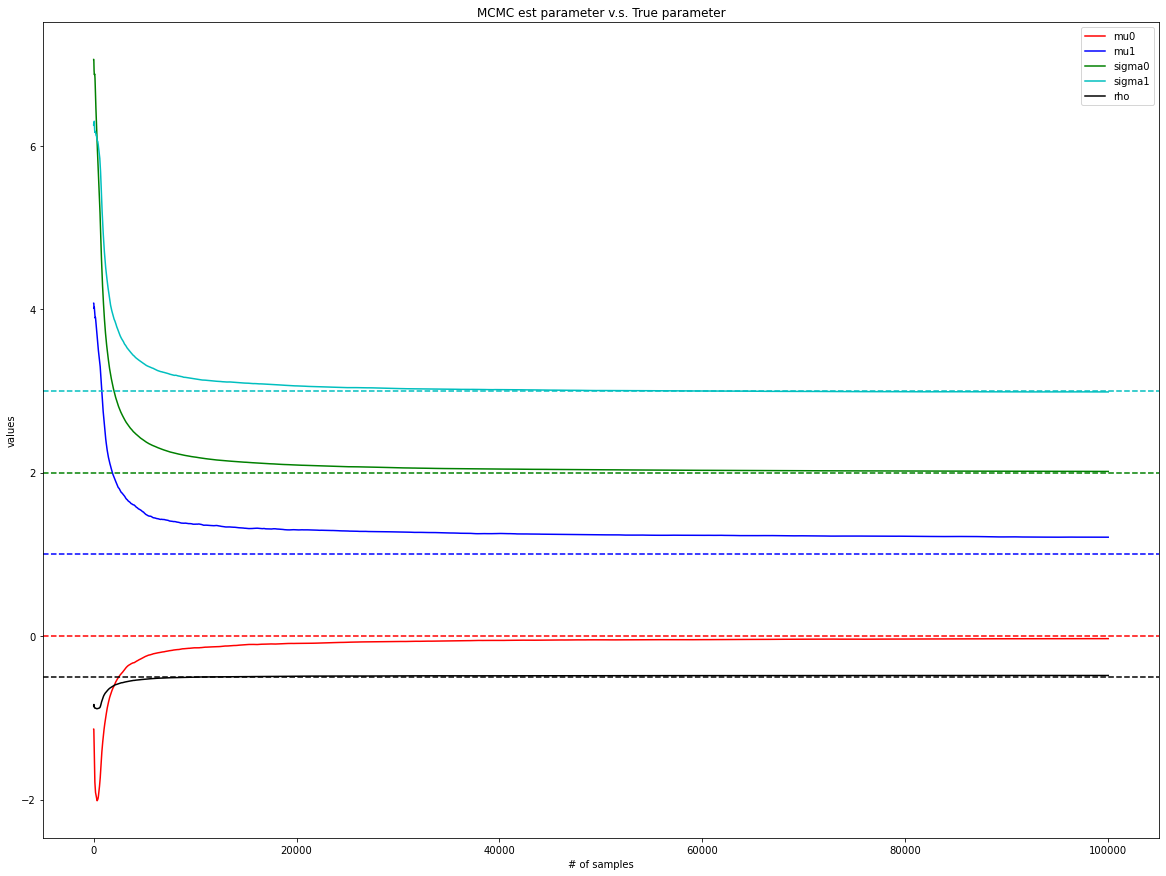

In [86]:
plt.figure(figsize=(20, 15))

plt.plot((mean_M1), c='r', label='mu0')
plt.axhline(m0, c='r', linestyle='--')
plt.plot((mean_M2), c='b', label='mu1')
plt.axhline(m1, c='b', linestyle='--')
plt.plot((mean_S1), c='g', label='sigma0')
plt.axhline(s0, c='g', linestyle='--')
plt.plot((mean_S2), c='c', label='sigma1')
plt.axhline(s1, c='c', linestyle='--')
plt.plot((mean_R), c='k', label='rho')
plt.axhline(rho, c='k', linestyle='--')

plt.legend()

plt.xlabel('# of samples')
plt.ylabel('values')
plt.title('MCMC est parameter v.s. True parameter')


## Corner plot

In [102]:
import corner

In [104]:
help(corner.corner)

Help on function corner in module corner.corner:

corner(data, bins=20, *, range=None, weights=None, color='k', hist_bin_factor=1, smooth=None, smooth1d=None, labels=None, label_kwargs=None, titles=None, show_titles=False, title_fmt='.2f', title_kwargs=None, truths=None, truth_color='#4682b4', scale_hist=False, quantiles=None, verbose=False, fig=None, max_n_ticks=5, top_ticks=False, use_math_text=False, reverse=False, labelpad=0.0, hist_kwargs=None, group='posterior', var_names=None, filter_vars=None, coords=None, divergences=False, divergences_kwargs=None, labeller=None, **hist2d_kwargs)
    Make a *sick* corner plot showing the projections of a data set in a
    multi-dimensional space. kwargs are passed to hist2d() or used for
    `matplotlib` styling.
    
    Parameters
    ----------
    data : obj
        Any object that can be converted to an ``arviz.InferenceData`` object.
        Refer to documentation of ``arviz.convert_to_dataset`` for details.
    
    bins : int or array_

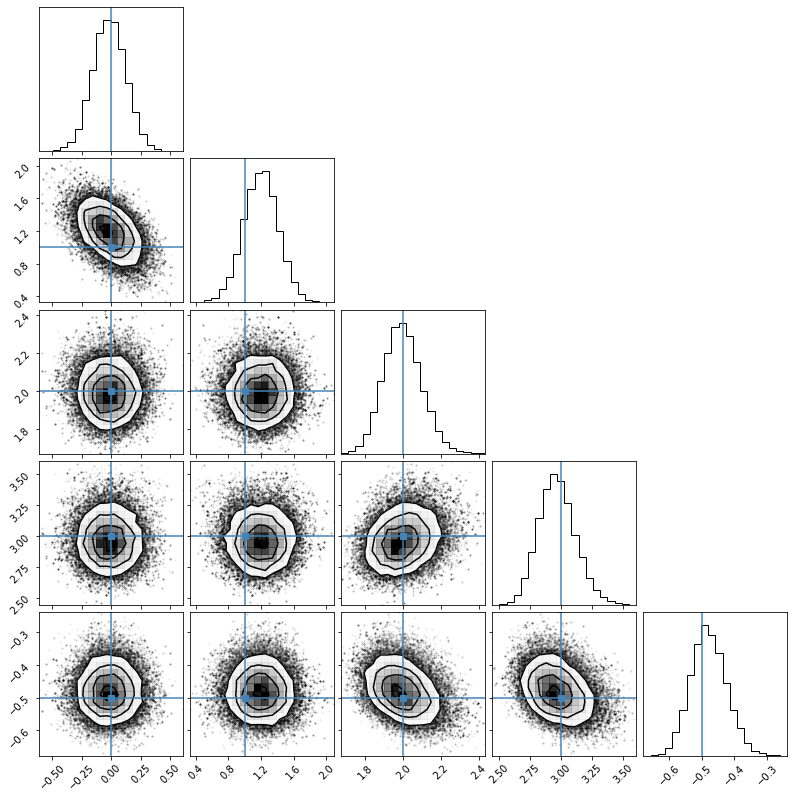

In [88]:
fig = corner.corner(
    pst_samples[10000:],
    labales = 'm0 m1 s0 s1 r'.split(),
    truths = true_theta
)

freak...

Text(0.5, 0, 'steps')

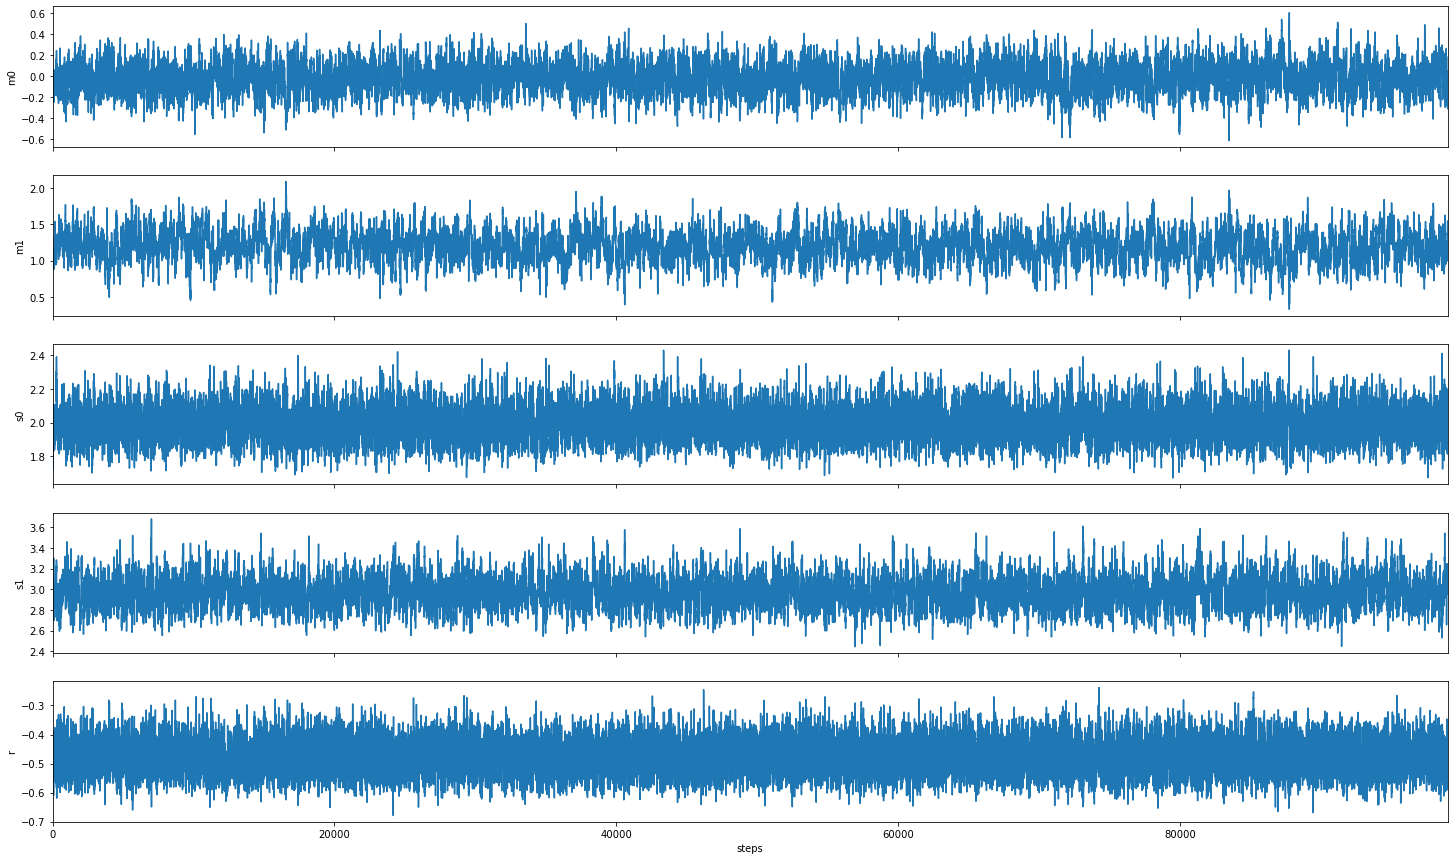

In [89]:
labels = 'm0 m1 s0 s1 r'.split()
lines  = pst_samples[1000:].T

fig, axes = plt.subplots(5, figsize=(25,15),sharex=True)

for i in range(5):
    ax = axes[i]
    ax.plot(lines[i])
    ax.set_xlim(0,len(lines[i]))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel('steps')

looks like a very inefficient sampler....

## ACF analysis

I can compute the acf for each parameter very easily. And therefore estimate the effective sample size. 

In [90]:
import statsmodels.api as sm

Text(0.5, 0.98, 'autocorrelation for each parameter')

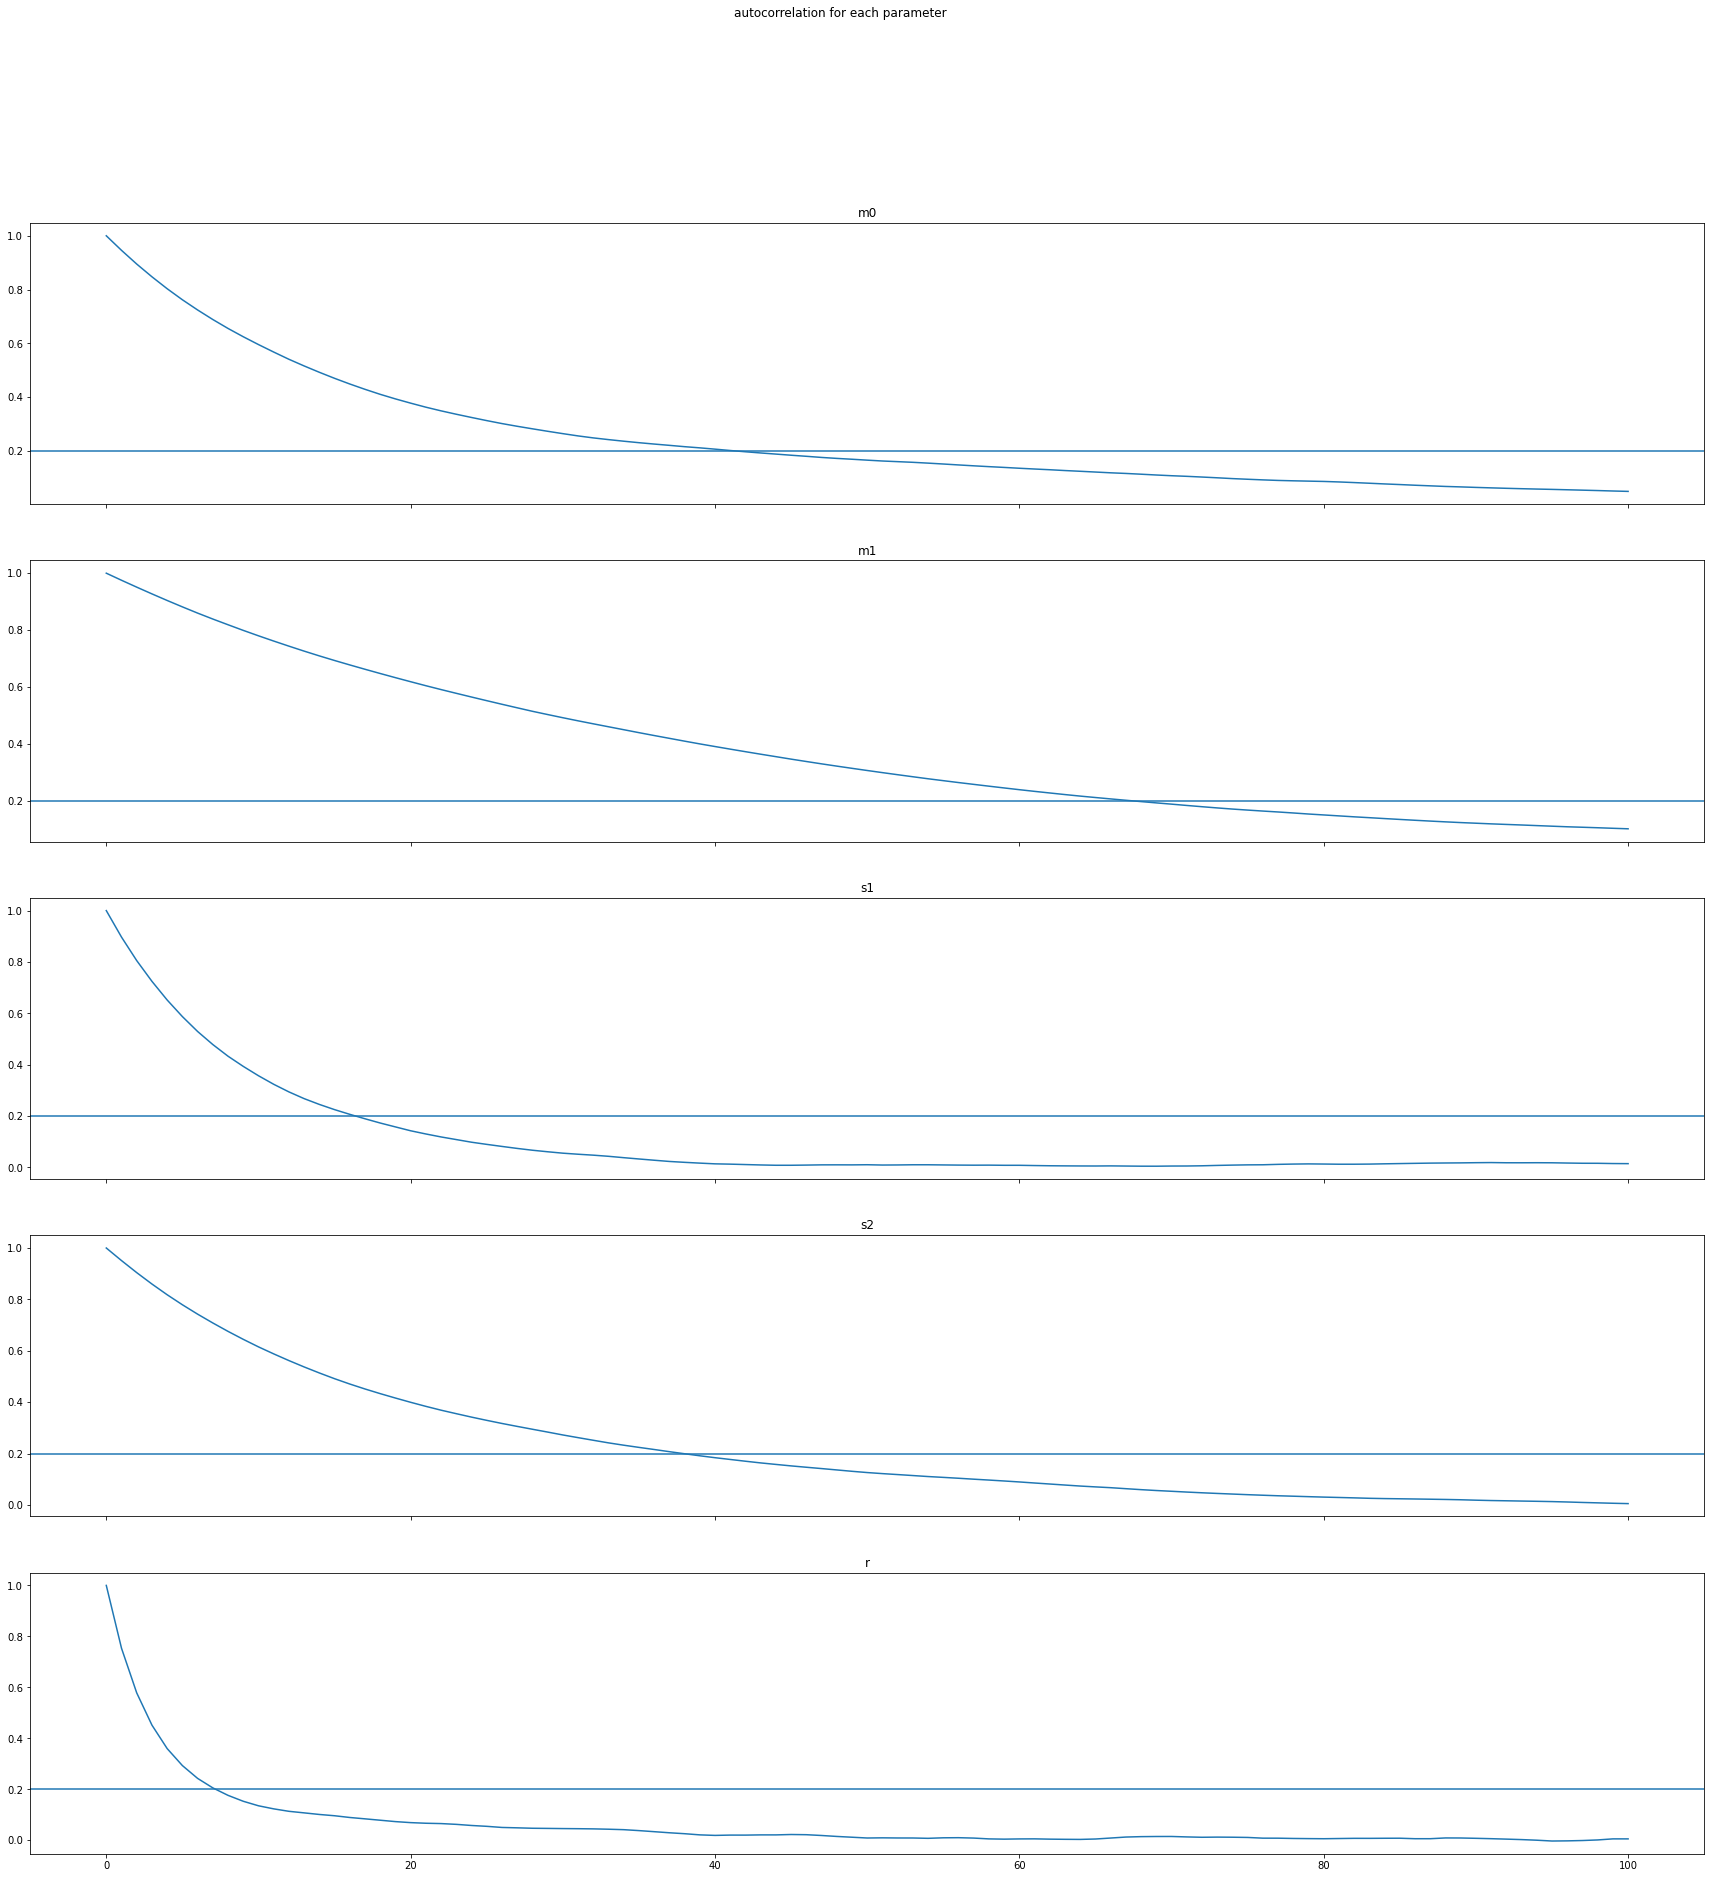

In [91]:
fig, axes = plt.subplots(5,1,sharex=True,figsize=(30,30))
names = 'm0 m1 s1 s2 r'.split()
for i in range(5):
    axes[i].plot(sm.tsa.acf(pst_samples[1000:,i],nlags=100))
    axes[i].set_title(names[i])
    axes[i].axhline(.2)
fig.suptitle('autocorrelation for each parameter')

## integrated time analysis

In [92]:
import emcee

In [93]:
for i in range(5):
    print(emcee.autocorr.integrated_time(pst_samples[1000:,i],tol=200))

[54.75907447]
[83.37106883]
[20.98963905]
[40.46433547]
[11.8811472]


## Estimators


In [94]:
mu_est = observation.mean(axis=0)

In [95]:
cov_est = np.mean(
    [np.matmul(i.reshape(2,1), i.reshape(1,2)) for i in observation-mu_est],
    axis=0)

In [96]:
(pst_samples[1000:].mean(axis=0) - flatten((mu_est,cov_est)))/(flatten((mu_est,cov_est)))

array([ 0.08681918,  0.0021443 ,  0.01155037,  0.01012218, -0.00920379])

In [99]:
log_likelyhood(flatten((mu_est,cov_est)),observation)

-892.4816786106526

In [100]:
log_likelyhood(pst_samples[1000:].mean(axis=0), observation)

-892.5440460300707

seems like my mcmc inference isn't so successful... 